### Abstract
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.

In this notebook we perform classification on whether a machine would be failed or not based on some factors and patterns. Process temperature of a machine is predicted for regression analysis.



Acknowledgement : https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset


In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Install Pandas, numopy,maplotlip,sklearn,eli5,tabulate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm  #importing statsmodel for OLS regression
from statsmodels.graphics.gofplots import qqplot
import category_encoders as ce
from sklearn import model_selection
from sklearn.model_selection import  train_test_split #for splitting data into train, test and validation data
from sklearn.linear_model import LinearRegression ,LogisticRegression # for fitting to get permutation
from sklearn import datasets, linear_model
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score , precision_score,recall_score,f1_score
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

In [5]:
# reading a dataframe using pandas
df = pd.read_csv("https://raw.githubusercontent.com/Venkata-Bhargavi/AutoML/main/predictive_maintenance%205.csv")

In [6]:
# saving a copy of original dataframe
df_copy = df.copy()

## Data Description

`UID`: unique identifier ranging from 1 to 10000

`productID`: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

`Air temperature [K]`: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
`Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

`Rotational speed [rpm]`: calculated from powepower of 2860 W, overlaid with a normally distributed noise

`Torque [Nm]`: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

`Tool wear [min]`: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
Important : There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.

`Target` : Failure or Not

`Failure Type` : Type of Failure

Acknowledgements

UCI : https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [7]:
# displaying top 5 rows of dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
df.shape

(10000, 10)

The data has 10,000 rows and 10 columns.

In [9]:
100*df.Target.value_counts(normalize=True)

0    96.61
1     3.39
Name: Target, dtype: float64

Target data has two classes 96.61% as 0's and 3.39% as 1's

In [10]:
df = df.drop(["UDI","Product ID","Failure Type"],axis = 1)

- Dropping `UDI` and `ProductID` columns as they are just a unique identifiers or numbers.
- Dropping `Failure Type` as it has same information as `Target` and can cause data leak i.e target variable will be present in training data which may lead to trouble in prediction.

In [11]:
# This gives information about dataset like column data types, column labels, number of columns, 
# number of cell in each column which are not null, range index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [12]:
df['Target'] = df['Target'].astype(object)

Converting data type of `Target` to object as it a categorical value but represented in integer


In [13]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [14]:
# No of Observations, No of features, No of features by type, Target %
# finding continuous and categorical features
numerical_ft = df.select_dtypes(include='number').columns.tolist()
categorical_ft = df.select_dtypes(include = 'object').columns.tolist()

In [15]:
numerical_ft,categorical_ft

(['Air temperature [K]',
  'Process temperature [K]',
  'Rotational speed [rpm]',
  'Torque [Nm]',
  'Tool wear [min]'],
 ['Type', 'Target'])

After dropping three features, there are 6 numerical features and 1 categorical features

#### Dataset has `10000` entries and `8` feature with `6` nominal and `2` categorical features with `3.39` Target `Failure` observations.
 Numerical features : `Air temperature [K]` `Process temperature [K]` `Rotational speed [rpm]` `Torque [Nm]` `Tool wear [min]` 
 
 Categorical features: `Type` `Failure Type` `Target`

## Data Types
* `Type` : is a categorical column as it has 3 classes H,M,L
* `Air temperature`,`Process temperature` : has float values representing temperature in Kelvin
* `Rotational speed` : has number of rotations per minute in Integer datatype.
* `Torque` : is measured in Newton meter (Nm) of data type float.
* `Tool wear` : is measured in minutes of data type Integer.
* `Target` : is a categorical value 
* `Failure Type` : is a categorical value of type "object"

## Missing values check

In [16]:
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64

#### Which independent variables have missing data ?

There are no missing values in the data

## Univariate analysis

 Numerical features : `Air temperature [K]` `Process temperature [K]` `Rotational speed [rpm]` `Torque [Nm]` `Tool wear [min]` `Target`

In [17]:
# provides some statistical information of data in dataframe
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


### Observations from above description

* `Air Temperature` has a mean of 300K and 75% of data is distributed between 295.3K and 301.5K, seems like a good distribution and may not have outliers.
* `Process temperature` has a mean of 310K and maximum data is distributed between 305.7K and 311.1K, looks good and may not have possible outliers.
* `Rotational speed` has a mean 1538 and 75% of data is distribbuted between 1168 and 1612 but the maximum value is 2886 and it looks like investigation is needed to understand outliers and it will be discussed further in this notebook.
* `Torque` has mean 39.9 , maximum value is 76.6, minimum value is 1168 and median is 40.1 which is slightly left skewed from mean.
* `Tool wear` has mean 107.9 and a median(2nd quantile) of 108 which is almost a normal distribution.

In [18]:
numerical_ft

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]']

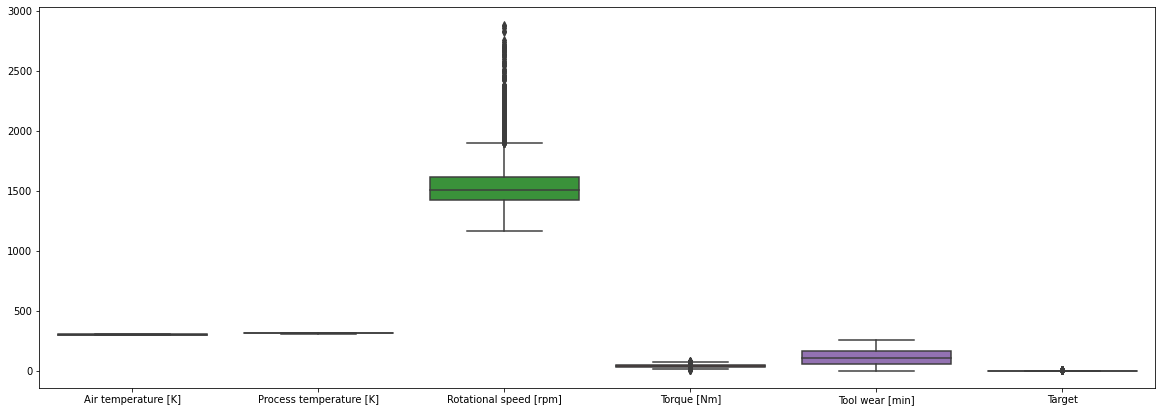

In [19]:
# checking distribution and ranges of predictor variables
plt.figure(figsize=(20,7))
sns.boxplot(data = df)

#### Does the data has Outliers?

Yes, the boxplot shows that there are visible outliers in `Rotational speed [rpm]` and should be imputed moving forward. This should be done before scaling to avoid skewness in data distribution.


In [20]:
# saving a copy of df to use it for modeling with outliers
df_with_outliers = df.copy()

### Outlier handling


 Inter Quantile Range Method:
- IQR is a concept in statistics that is used to measure the statistical dispersion and data variability by dividing the dataset into quartiles.
- Q1 (1st Quantile) = df.quantile(0.25)
- Q3 (3rd Quantile)= df.quantile(0.75)
- IQR = Q3-Q1
- LowerLimit = Q1-1.5*IQR
- UpperLimit = Q3+1.5*IQR
why we use 1.5 as a factor --> as Standard Devaiation method, 1 IQR from Q1 & Q2 covers approx ~70% of the data and 2 IQR covers approx ~ 97% of the data. so it is aproximated that 1.5 factor will cover approx ~95% of the data.
Anything outside the`LowerLimit` and `UpperLimit` are can be replaced with Median or Mean or Mode.

In [21]:
#  using IQR method to impute outliers
def handle_outliers_iqr(df, feature,fac): # df = dataframe , feature = each feature , fac = 1.5 or 2 based on the use case
    Qan1 = df[f"{feature}"].quantile(0.25)
    Qan3 = df[f"{feature}"].quantile(0.75)
    IQR=Qan3-Qan1
    lower_limit=Qan1-fac*IQR
    upper_limit=Qan3+fac*IQR
    df.loc[(df[feature] < lower_limit) | (df[feature] > upper_limit), feature] = df[feature].mean()
    return df



In [22]:
handle_outliers_iqr(df , "Rotational speed [rpm]" , 1.5)
handle_outliers_iqr(df , "Torque [Nm]" , 1.5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551.0,42.8,0,0
1,L,298.2,308.7,1408.0,46.3,3,0
2,L,298.1,308.5,1498.0,49.4,5,0
3,L,298.2,308.6,1433.0,39.5,7,0
4,L,298.2,308.7,1408.0,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604.0,29.5,14,0
9996,H,298.9,308.4,1632.0,31.8,17,0
9997,M,299.0,308.6,1645.0,33.4,22,0
9998,H,299.0,308.7,1408.0,48.5,25,0


In [23]:
df[["Rotational speed [rpm]"]].describe(), df[["Rotational speed [rpm]"]].quantile(0.25), df[["Rotational speed [rpm]"]].quantile(0.75)

(       Rotational speed [rpm]
 count            10000.000000
 mean              1515.231441
 std                127.833761
 min               1168.000000
 25%               1423.000000
 50%               1503.000000
 75%               1589.000000
 max               1895.000000, Rotational speed [rpm]    1423.0
 Name: 0.25, dtype: float64, Rotational speed [rpm]    1589.0
 Name: 0.75, dtype: float64)

In `Rotational speed [rpm]`

(1589.0-1423.0) = 166(IQR)

1423-249 = 1174 ,

1589(75% value)+249(1.5 times IQR) = 1838
- outliers in the region 1838 and 1895(max value) are handled and replaced by mean 
- outlier between 1589 and 1838 are considered in the distribution and significant

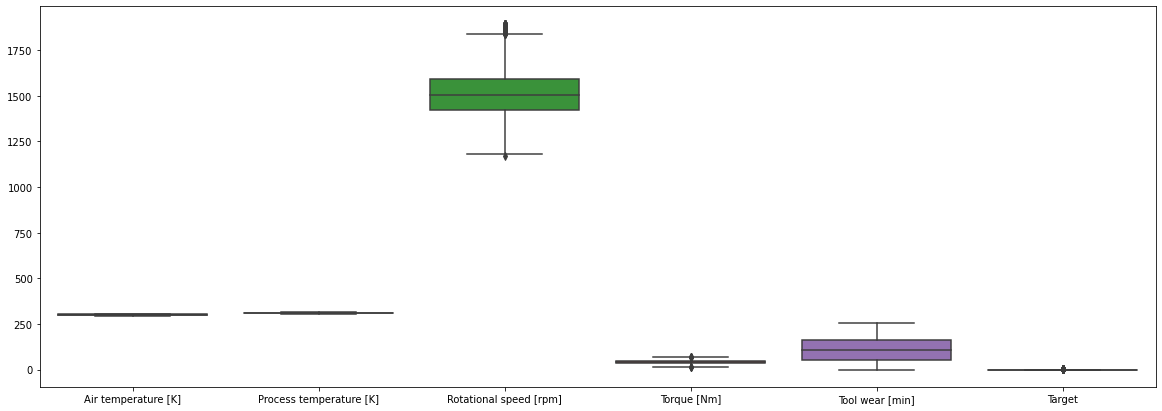

In [24]:
plt.figure(figsize=(20,7))
sns.boxplot(data = df)

#### The above diagram shows that all the predictors are not in the same range. So, it is advisable to scale all the features in same range for better modelling.
#### Scaling can be done in different ways like
1. Normalizing
2. Standardizing

- Normalization is effective when you know that your data is not following a Gaussian distribution(bell curve) and it scales the data in between 0 and 1.
- Standardization can be used when the data follows Gaussian distribution. However it need not necessarily be the exact Gaussian distribution but it is effective on a gaussianlly distributed data.


In [25]:


# Normalizing the data in the rings column beacuse the value is too high when compared to other independent variable

from sklearn import preprocessing

num_feat = ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]
# Create x to store scaled values as floats
x = df[num_feat].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df[num_feat] = pd.DataFrame(x_scaled)

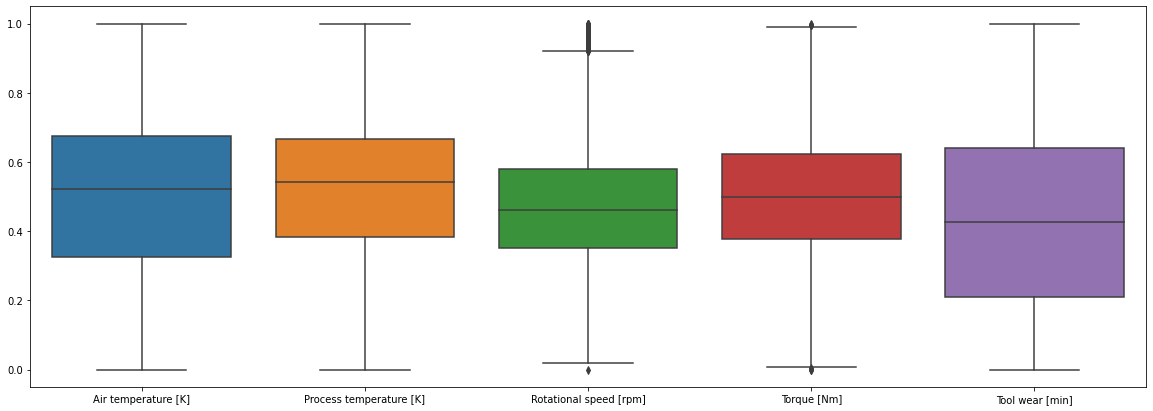

In [26]:
# plotting box plot again to check the distribution after outlier handling
plt.figure(figsize=(20,7))
sns.boxplot(data = df[num_feat])

All features are in same scale and are comparible. Few features still have variance in data 




### Ordinal Encoder

To order the rank of features , in this case L,M,H has ordering like low, medium and high so ordinal encoders are used to preserve the order of the data points

In [27]:
Type_encoder = ce.OrdinalEncoder(cols=['Type'], return_df=True, mapping=[{'col':'Type','mapping':{'L':1,'M':2,'H':3}}])
df['Type'] = Type_encoder.fit_transform(df['Type'])




In [28]:
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.358025,0.526823,0.551852,0.000000,0
1,1,0.315217,0.370370,0.330124,0.616667,0.011858,0
2,1,0.304348,0.345679,0.453920,0.674074,0.019763,0
3,1,0.315217,0.358025,0.364512,0.490741,0.027668,0
4,1,0.315217,0.370370,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...,...
9995,2,0.380435,0.333333,0.599725,0.305556,0.055336,0
9996,3,0.391304,0.333333,0.638239,0.348148,0.067194,0
9997,2,0.402174,0.358025,0.656121,0.377778,0.086957,0
9998,3,0.402174,0.370370,0.330124,0.657407,0.098814,0


## Feature Importance
Few independent variables contribute a lot in predicting target variable and few don't. This can be understood through various methods and helps in eliminating variables that contribute's less in the analysis

### Heat Map

Heatmap shows the magnitude of a feature by visualizing the intensity through colours and helps in understanding features that matters the most

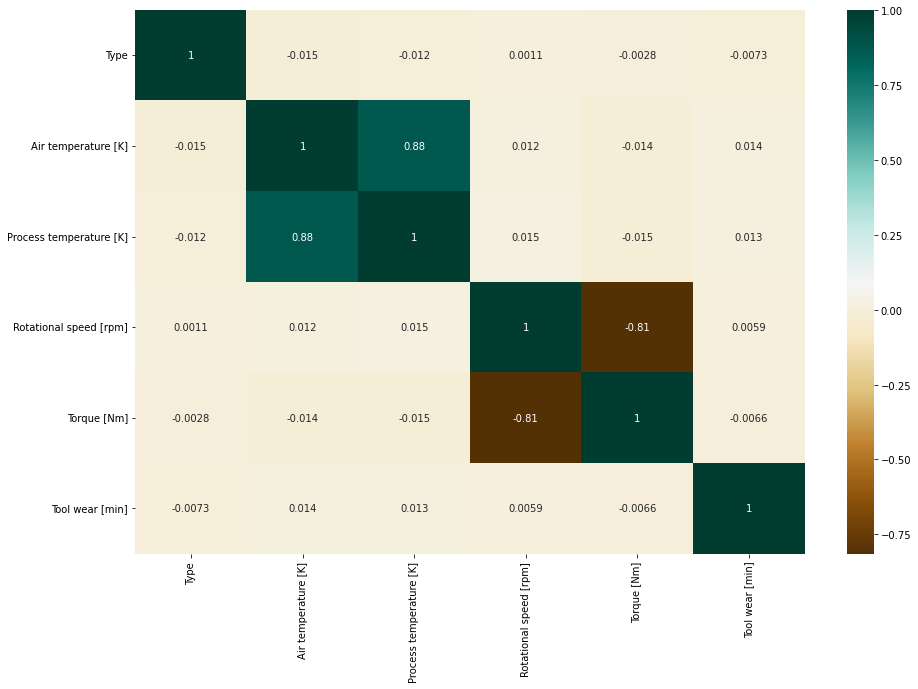

In [29]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot = True,cmap="BrBG")

### Observations
- Above heapmap shows that `Air teamperature [k]` and `Process temperature [k]` are highly correlated.
- `Torque` has high correlation comparing to other feature with Target
- `Torque` and `Rotational speed [Nm]` are negatively correlated i.e if Rotational speed increases then Torque decreases and vice versa.
- `Type` has slight correlation with `Rotational speed [Nm]` comparing to other features but it doesn't seem like multi colinearity as the value is very low.


As its important to check whether the both the correlated features are necessary for prediction or should one of them be removed.

`Air teamperature [k]` and  `Process temperature [k]` are gaving 0.88 correlated to each other and `Air teamperature [k]` w.r.t `Target` has 0.083 while `Process temperature [k]` w.r.t `Target` has 0.036 which shows that one can be removed and it is `Process temperature [k]`  let's strongly confirm with permutation importance menthod later.

To see interaction between independent features let's check correlation through pariplot

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  float64
 6   Target                   10000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  float64
 6   Target                   10000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB


###**Question - 1**

### OLS regression

Ordinary Least Square Regressions tell us relationship between one or more independent variables with a dependent variable. Helps us in estimating coefficients of linear regression.

In [32]:
cols = df.columns.tolist()
cols.remove("Process temperature [K]")
# cols = ["Type"]
df.Target = df.Target.astype(int)
model = sm.OLS(df["Process temperature [K]"], df[cols]).fit()
model.summary() #sumarizes the stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Process temperature [K]   R-squared (uncentered):                   0.975
Model:                                 OLS   Adj. R-squared (uncentered):              0.975
Method:                      Least Squares   F-statistic:                          6.434e+04
Date:                     Tue, 06 Dec 2022   Prob (F-statistic):                        0.00
Time:                             02:58:40   Log-Likelihood:                          9966.5
No. Observations:                    10000   AIC:                                 -1.992e+04
Df Residuals:                         9994   BIC:                                 -1.988e+04
Df Model:                                6                                                  
Covariance Type:                 nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Type                       0.0052      0.001      4.032      0.000       0.003       0.008
Air temperature [K]        0.7576      0.004    189.338      0.000       0.750       0.765
Rotational speed [rpm]     0.1319      0.004     30.800      0.000       0.124       0.140
Torque [Nm]                0.1343      0.004     32.748      0.000       0.126       0.142
Tool wear [min]            0.0141      0.004      4.017      0.000       0.007       0.021
Target                    -0.0386      0.005     -7.591      0.000      -0.049      -0.029
==============================================================================
Omnibus:                      289.434   Durbin-Watson:                   0.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.209
Skew:                           0.272   Prob(JB):                     2.51e-48
Kurtosis:                       2.520   Cond. No.                         11.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###**Observations** :

The above stats show that all the features have p value < 0.05 so they are significant
- In above model dependent variable is `Process temperature [K]`, `Air temperature [K]`'s coefficient is very high which shows colinearity
- The next highest coefficient is `Torque [Nm]`
- `Type` variable shows least coefficient of all demostrating the lower contrinution to the dependent variable

### Permutation Importance

In [33]:
def get_permutation_importance(df):
    X = df[["Type","Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]]
    y = df[["Target"]]
    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.10, random_state=1)
    # Create linear regression object
    model = linear_model.LinearRegression()
    model.fit(X_train,y_train)
    pi = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    return eli5.show_weights(pi, feature_names = X_test.columns.tolist())



#  https://scikit-learn.org/stable/modules/permutation_importance.html

In [34]:
get_permutation_importance(df)

Weight,Feature
0.1266 ± 0.0227,Air temperature [K]
0.0532 ± 0.0178,Process temperature [K]
0.0235 ± 0.0136,Rotational speed [rpm]
0.0193 ± 0.0074,Tool wear [min]
0.0137 ± 0.0070,Torque [Nm]
0.0017 ± 0.0052,Type


From above scores it is evident that `Process temperature [K]` has low importance than `Air temperature [K]` in model prediction , let's go ahead and remove `Process temperature [K]`


In [35]:
df = df.drop("Process temperature [K]",axis = 1)

In [36]:
df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.526823,0.551852,0.000000,0
1,1,0.315217,0.330124,0.616667,0.011858,0
2,1,0.304348,0.453920,0.674074,0.019763,0
3,1,0.315217,0.364512,0.490741,0.027668,0
4,1,0.315217,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...
9995,2,0.380435,0.599725,0.305556,0.055336,0
9996,3,0.391304,0.638239,0.348148,0.067194,0
9997,2,0.402174,0.656121,0.377778,0.086957,0
9998,3,0.402174,0.330124,0.657407,0.098814,0



### Oversampling


Data in target variable is not balanced so over sampling is required and it helps in building a model with decent scores

In [37]:
class_Fail = df[df['Target'] == 0]
class_No_Fail = df[df['Target'] == 1]
class_No_Fail = class_No_Fail.sample(len(class_Fail),replace=True)
over_sampled_df = pd.concat([class_Fail, class_No_Fail], axis=0)


print('OverSampled Data Distribution:\n',over_sampled_df['Target'].value_counts())



OverSampled Data Distribution:
 0    9661
1    9661
Name: Target, dtype: int64


In [38]:
over_sampled_df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,0.304348,0.526823,0.551852,0.000000,0
1,1,0.315217,0.330124,0.616667,0.011858,0
2,1,0.304348,0.453920,0.674074,0.019763,0
3,1,0.315217,0.364512,0.490741,0.027668,0
4,1,0.315217,0.330124,0.500000,0.035573,0
...,...,...,...,...,...,...
6525,1,0.630435,0.198074,0.499758,0.193676,1
207,2,0.336957,0.348006,0.883333,0.470356,1
603,1,0.282609,0.231087,0.499758,0.122530,1
4153,2,0.728261,0.060523,0.788889,0.312253,1


### Train , Test and validation split

In [39]:
independent_cols = ["Type","Air temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]

X = over_sampled_df[independent_cols]
y = over_sampled_df["Target"]

In [40]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)



# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

###**Shap Analysis**
SHAP shows the impact of each feature by interpreting the impact of a certain value compared to a baseline value. Helps to increase transparency and interpretability of machine learning models

In [41]:
import shap
shap.initjs()
model = LinearRegression()
model.fit(X_test, y_test)

LinearRegression()

In [42]:
explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

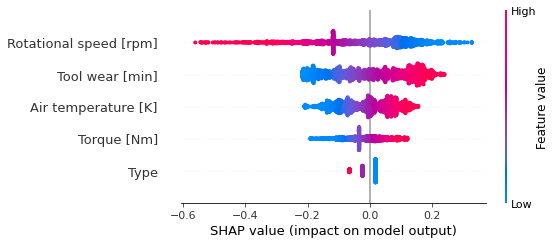

In [43]:
shap.summary_plot(shap_values, X_test)

### **Observations :**

From above summary
- High `Rotational speed` is leading to low `Process Temperature`, this sounds strange as high `rotational speed` increases temperature in general
- High `Tool wear` is leading to high `process temperature` which is true and it isn't contributing as much as `Rotational speed` does but the density is widely spread
- When Type is high(a categorical variable) `process temperature` is aroud -0.1 likewise when Type low `process tempeature` is between 0 and 1 and the density is high for this category, this fairly matches with the OLS regression's inference



## Modeling

###**Question - 2**
###Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier( n_estimators = 100,
                                 max_features = 0.2,
                                 max_depth = 10,
                                 max_samples = 0.5)

In [45]:
rf_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, max_features=0.2, max_samples=0.5)

In [46]:
print(f"Model Score on Training Data: {rf_clf.score(X_train,y_train)}")
print(f"Model Score on Test Data: {rf_clf.score(X_test,y_test)}")
print(f"Model Score on Validation Data: {rf_clf.score(X_val, y_val)}")

Model Score on Training Data: 0.984979702300406
Model Score on Test Data: 0.9777547853078117
Model Score on Validation Data: 0.9739363740896896


<BarContainer object of 5 artists>

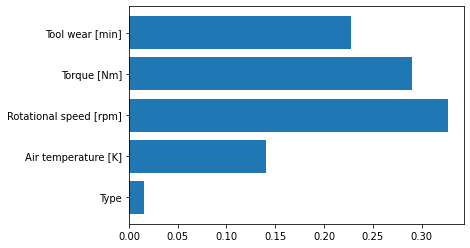

In [47]:
plt.barh(independent_cols, rf_clf.feature_importances_)


### Observations
From the above festure importance
- The `Rotational speed` variable shows high importance than other features in predicting the `process temperature`
- Type shows low importance as justified in linear models too, looks like the type of the machine has no much impact on `process temperature`


In [48]:
explainer = shap.TreeExplainer( rf_clf )

shap_values = explainer.shap_values( X_test )


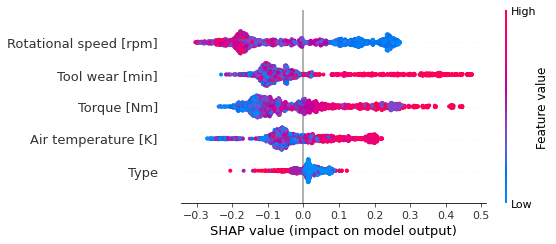

In [49]:
shap.summary_plot( shap_values[1], X_test, plot_type = 'dot' )

### **Observations :**
From above shap summary
- The lower the `Rotational speed` the `process temperature` is a definite high, yet with medium and high Rotational speed the process temperature is low. The feature importance shows that `Rotational speed` feature is of high importance 
- When `Tool wear` is high , the `process temperature` is high and increasing which is similar to the linear model inference
- when Type is high model then process temperature is low most of the time
- Higher the `Air temperature` is higher the `process temperature` which shows the colinearity but the distribution is a little different from the one in liner model


###Using Decision tree classifier for node interpretation

In [73]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [76]:
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X_train, y_train) # fitting the decision tree model

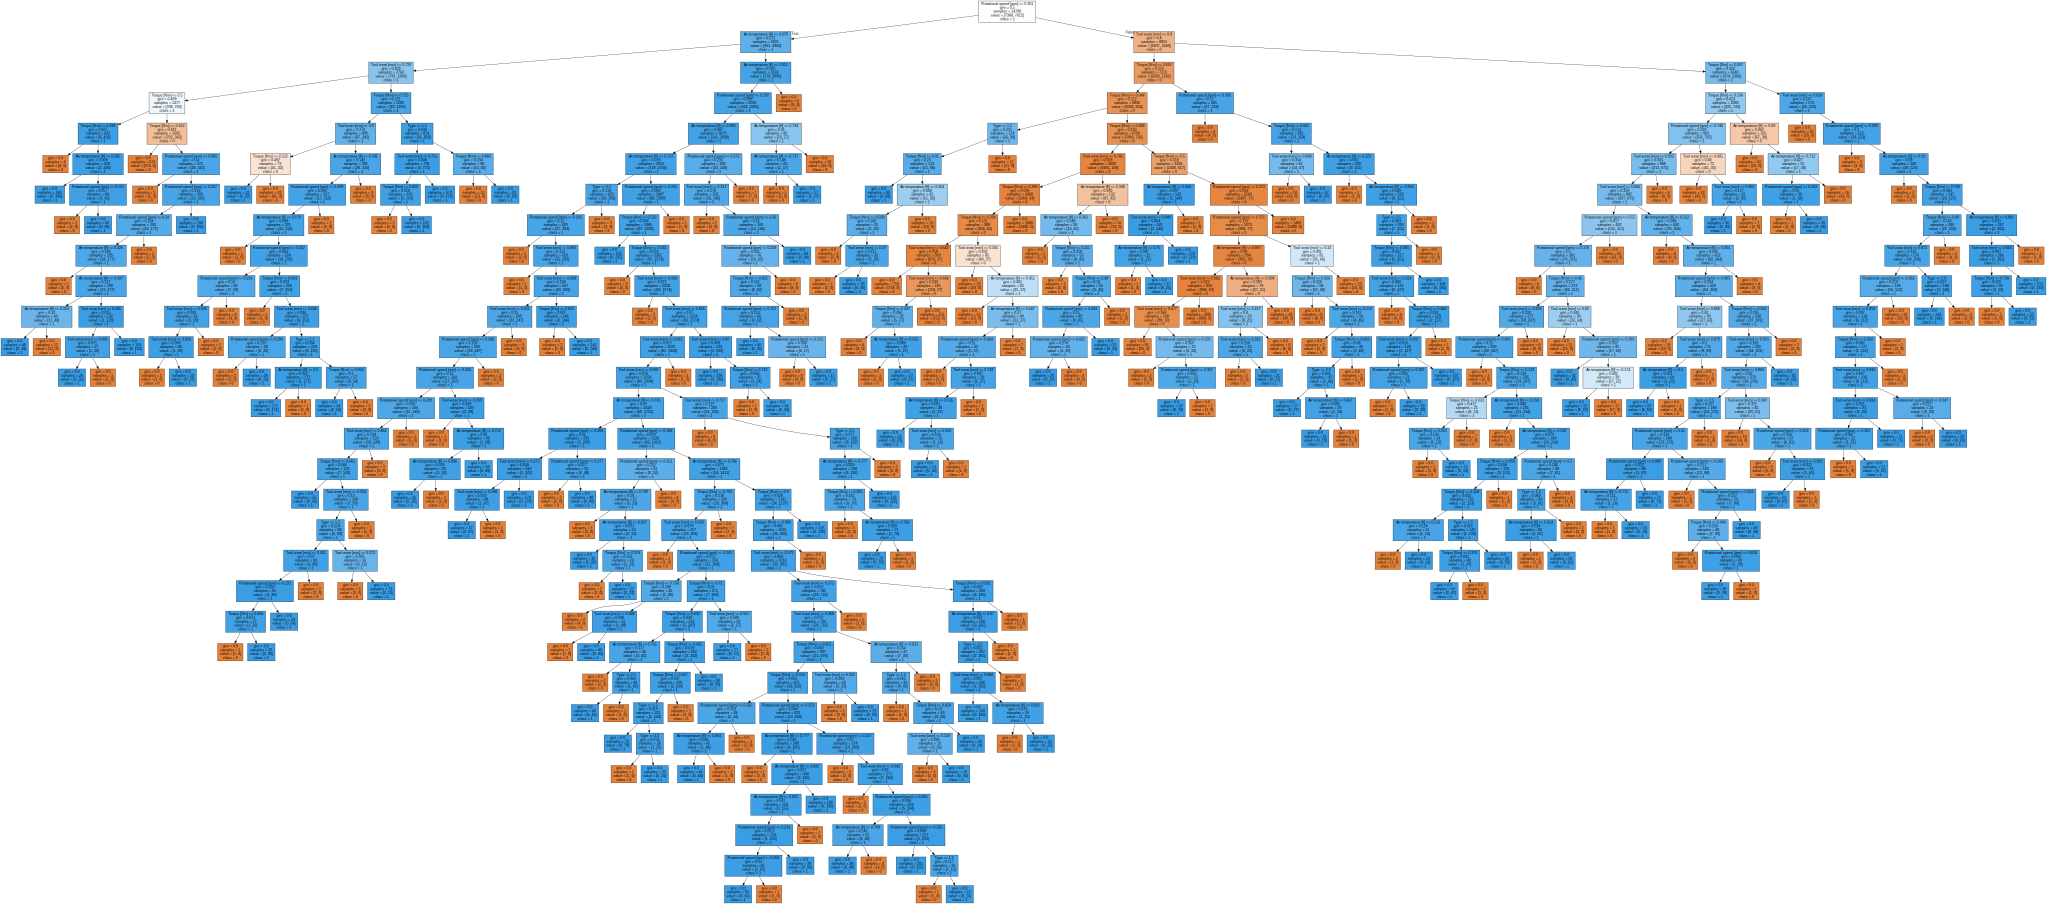

In [78]:
# independent_cols = ["Type","Air temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]

import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=independent_cols,  
                                class_names=["0","1"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

### Observations

From above tree
- Rotational speed in chosen as root node with a gini index of 0.5
- Further `Air temperature` and `Tool wear` with min impurity is chosen as node
- The leaf node shows the pure classification
- The depth of the tree is too high and its hard to mention the overall inference


###**Question - 3**


Using h2o AutoML to find the best model

In [50]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7rzsdm5w
  JVM stdout: /tmp/tmp7rzsdm5w/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7rzsdm5w/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_6zkbx5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [53]:
from h2o.automl import H2OAutoML

In [54]:
df = h2o.import_file('https://raw.githubusercontent.com/Venkata-Bhargavi/AutoML/main/predictive_maintenance%205.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [55]:
df.types # checking the data types of all the features

{'\ufeffUDI': 'int',
 'Product ID': 'string',
 'Type': 'enum',
 'Air temperature [K]': 'real',
 'Process temperature [K]': 'real',
 'Rotational speed [rpm]': 'int',
 'Torque [Nm]': 'real',
 'Tool wear [min]': 'int',
 'Target': 'int',
 'Failure Type': 'enum'}

Here, in this data Target is a categorical feature but represented as integer and should be converted to categorical feature.

In [56]:
df.describe()

Rows:10000
Cols:10

,﻿UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
type,int,string,enum,real,real,int,real,int,int,enum
mins,1.0,NaN,,295.3,305.7,1168.0,3.8,0.0,0.0,
mean,5000.5,NaN,,300.00493,310.00556,1538.7761000000003,39.98690999999997,107.95100000000005,0.033900000000000007,
maxs,10000.0,NaN,,304.5,313.8,2886.0,76.6,253.0,1.0,
sigma,2886.8956799071675,NaN,,2.0002586829158036,1.4837342191657434,179.2840959134266,9.968933725121339,63.654146636636355,0.18098084265065364,
zeros,0,0,,0,0,0,0,120,9661,
missing,0,0,0,0,0,0,0,0,0,0
0,1.0,M14860,M,298.1,308.6,1551.0,42.8,0.0,0.0,No Failure
1,2.0,L47181,L,298.2,308.7,1408.0,46.3,3.0,0.0,No Failure
2,3.0,L47182,L,298.1,308.5,1498.0,49.4,5.0,0.0,No Failure


### Observations from above description

* `Air Temperature` has a mean of 300K and 75% of data is distributed between 295.3K and 301.5K, seems like a good distribution and may not have outliers.
* `Process temperature` has a mean of 310K and maximum data is distributed between 305.7K and 311.1K, looks good and may not have possible outliers.
* `Rotational speed` has a mean 1538 and 75% of data is distribbuted between 1168 and 1612 but the maximum value is 2886 and it looks like investigation is needed to understand outliers and it will be discussed further in this notebook.
* `Torque` has mean 39.9 , maximum value is 76.6, minimum value is 1168 and median is 40.1 which is slightly left skewed from mean.
* `Tool wear` has mean 107.9 and a median(2nd quantile) of 108 which is almost a normal distribution.


All the quantile information 

In [57]:
pdf = pd.read_csv("https://raw.githubusercontent.com/Venkata-Bhargavi/AutoML/main/predictive_maintenance%205.csv")
pdf.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


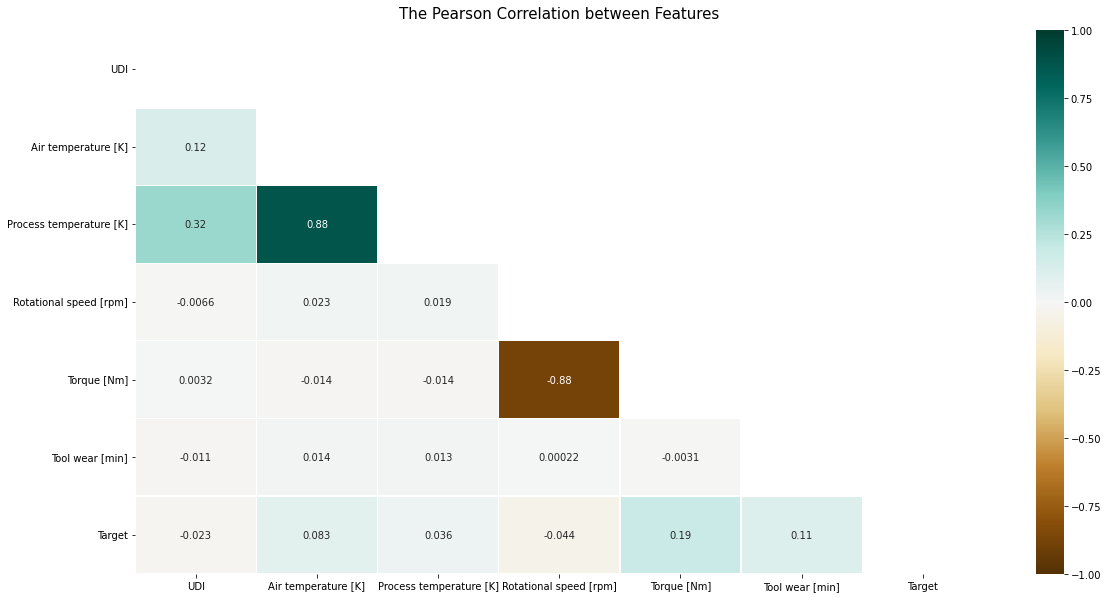

In [58]:
# For Data Visualization
import numpy as np
data_corr = pdf.corr()
mask = np.triu(np.ones_like(pdf.corr(), dtype=bool))
corr_ft = plt.figure(figsize= (19, 10))
corr_ft = sns.heatmap(data_corr, mask=mask,vmin= -1, vmax = 1, annot=True, linewidths= 0.3, cmap= "BrBG")
corr_ft.set_title("The Pearson Correlation between Features",
                   fontsize= 15,
                   pad= 12)
plt.show()

### Observations
- Above heapmap shows that `Air teamperature [k]` and `Process temperature [k]` are highly correlated.
- `Torque` has high correlation comparing to other feature with Target
- `Torque` and `Rotational speed [Nm]` are negatively correlated i.e if Rotational speed increases then Torque decreases and vice versa.
- `Type` has slight correlation with `Rotational speed [Nm]` comparing to other features but it doesn't seem like multi colinearity as the value is very low.


In [59]:
df["Target"] = df["Target"].asfactor()

Converting `Target` column to enum as it is given integer but need to classify it

In [60]:
train,test,valid = df.split_frame(ratios=[.7, .15])

Splitting train test and vailidation into 70:15:15 ratio.

Here the Target variable is `Process temperature [K]` for regression

In [61]:
y = "Process temperature [K]"
x = df.columns
x.remove(y)
x.remove("Product ID")
x.remove("Failure Type")
x.remove("\ufeffUDI")

- Here the target feature is `Process temperature [K]` for regression.
- Removing `Product ID`, `Failure Type`, `UDI` as product Id and UDI are just unique identifiers and dont contribute for the analysis
- Removing `Failure Type` as it has the failure type information which is similar to target feature and may lead to data leakage

In [62]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


Excluding StackedEnsemble and DeepLearning as it is more complex at this moment and it is also an expensive process

In [63]:
# !nvidia-smi

In [64]:
aml.train(x = x, y = y, training_frame = train, validation_frame=valid)

AutoML progress: |
02:59:29.16: Project: AutoML_1_20221206_25928
02:59:29.18: Cross-validation disabled by user: no fold column nor nfolds > 1.
02:59:29.20: Setting stopping tolerance adaptively based on the training frame: 0.011969397463728037
02:59:29.20: Build control seed: 10
02:59:29.21: training frame: Frame key: AutoML_1_20221206_25928_training_py_3_sid_b26f    cols: 10    rows: 6980  chunks: 8    size: 176192  checksum: -904089984631596151
02:59:29.27: validation frame: Frame key: py_5_sid_b26f    cols: 10    rows: 1513  chunks: 8    size: 55576  checksum: 5757435877646071311
02:59:29.28: leaderboard frame: Frame key: py_5_sid_b26f    cols: 10    rows: 1513  chunks: 8    size: 55576  checksum: 5757435877646071311
02:59:29.29: blending frame: NULL
02:59:29.29: response column: Process temperature [K]
02:59:29.29: fold column: null
02:59:29.29: weights column: null
02:59:29.181: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 9

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,60.0,60.0,51806.0,7.0,7.0,7.0,19.0,100.0,64.01667
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2022-12-06 02:59:49,0.004 sec,0.0,1.4832321,1.2291869,2.1999776,1.4681624,1.2147931,2.1555007
,2022-12-06 02:59:49,0.156 sec,5.0,1.0778473,0.9007475,1.1617548,1.0716569,0.8966077,1.1484485
,2022-12-06 02:59:50,0.292 sec,10.0,0.8453415,0.7110380,0.7146023,0.8485547,0.7147223,0.7200450
,2022-12-06 02:59:50,0.445 sec,15.0,0.7425472,0.6223787,0.5513763,0.7549534,0.6352385,0.5699546
,2022-12-06 02:59:50,0.577 sec,20.0,0.6977224,0.5815442,0.4868166,0.7161049,0.6001610,0.5128063
,2022-12-06 02:59:50,0.736 sec,25.0,0.6630883,0.5492523,0.4396861,0.6896519,0.5746148,0.4756197
,2022-12-06 02:59:50,0.872 sec,30.0,0.6241363,0.5102692,0.3895462,0.6587538,0.5424152,0.4339566
,2022-12-06 02:59:50,0.996 sec,35.0,0.6029282,0.4871969,0.3635224,0.6455596,0.5260955,0.4167472


Training the AutoML with training data 

In [65]:
lb = aml.leaderboard

In [66]:
best_model = aml.get_best_model()

In [67]:
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20221206_25928


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    60                 60                          51806                  7            7            7             19            100           64.0167

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.31810994074429066
RMSE: 0.5640123586804554
MAE: 0.4461861378142349
RMSLE: 0.0018128198977860424
Mean Residual Deviance: 0.31810994074429066

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.40920489044988434
RMSE: 0.6396912461882563
MAE: 0.5124583529389948
RMSLE: 0.0020565128540862604
Mean Residual Deviance: 0.409204890

Checking the best model performance on test data , this is same as using best model above

In [68]:
aml.leader.model_performance(test)  

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.43210698829410454
RMSE: 0.6573484527205525
MAE: 0.5237515831529258
RMSLE: 0.0021127411893109424
Mean Residual Deviance: 0.43210698829410454

MSE: 0.4231708305048506

RMSE: 0.6505158187967842

MAE: 0.5159975791212378

RMSLE: 0.0020907927202465405




MAE and RMSE scores are not highly varying this means that the outliers are less and not effecting the performance. (when squared in RMSE if the outliers are present then it would increase the error to greater extent)

In [69]:
aml.leader.model_performance(valid) # model performance on validation data

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.40920489044988434
RMSE: 0.6396912461882563
MAE: 0.5124583529389948
RMSLE: 0.0020565128540862604
Mean Residual Deviance: 0.40920489044988434

In [70]:
import shap
shap.initjs()


# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo,predict
GBM_2_AutoML_1_20221206_25928,0.657348,0.432107,0.523752,0.00211274,0.432107,1603,0.02868,GBM,308.478
GBM_3_AutoML_1_20221206_25928,0.663624,0.440396,0.52734,0.00213291,0.440396,1449,0.037351,GBM,308.71
XGBoost_3_AutoML_1_20221206_25928,0.663733,0.440541,0.530046,0.00213331,0.440541,751,0.007959,XGBoost,308.679
GBM_1_AutoML_1_20221206_25928,0.66614,0.443742,0.537124,0.00214093,0.443742,4854,0.025867,GBM,308.52
XRT_1_AutoML_1_20221206_25928,0.670534,0.449615,0.53547,0.00215525,0.449615,6631,0.046822,DRF,308.546
GBM_4_AutoML_1_20221206_25928,0.67083,0.450013,0.527488,0.00215601,0.450013,1745,0.037142,GBM,308.532
DRF_1_AutoML_1_20221206_25928,0.674027,0.454313,0.534167,0.00216648,0.454313,7440,0.052794,DRF,308.441
XGBoost_2_AutoML_1_20221206_25928,0.696654,0.485327,0.54928,0.00223898,0.485327,1803,0.009862,XGBoost,308.808
XGBoost_1_AutoML_1_20221206_25928,0.710611,0.504967,0.561648,0.00228385,0.504967,4136,0.012932,XGBoost,308.514
GLM_1_AutoML_1_20221206_25928,0.728629,0.5309,0.600504,0.00234167,0.5309,1161,0.003472,GLM,308.965


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

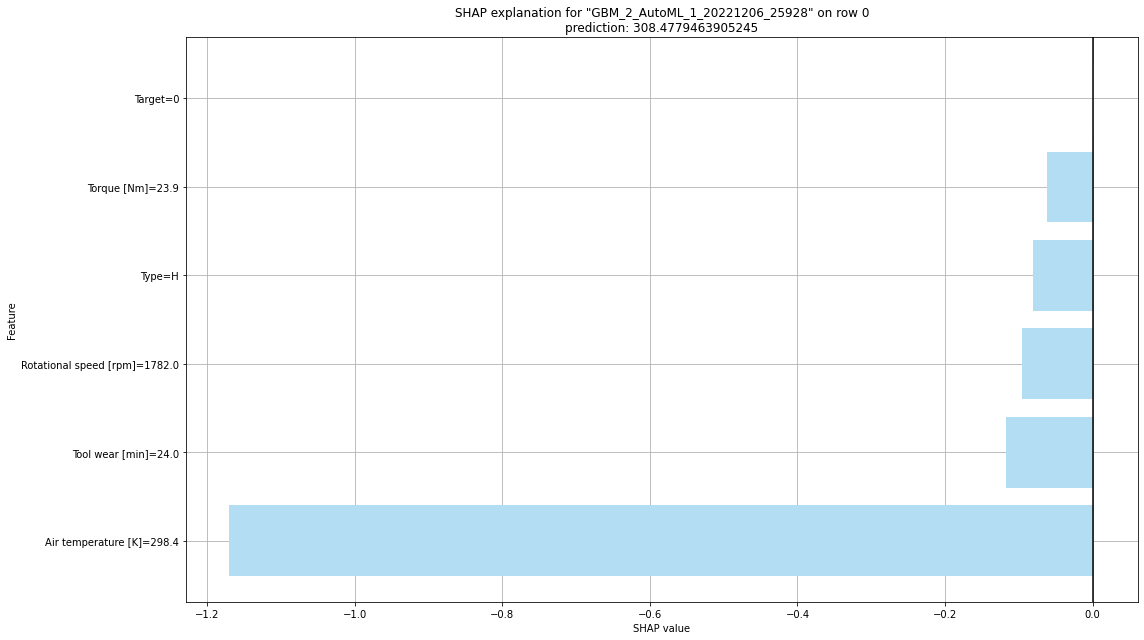

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo,predict
GBM_2_AutoML_1_20221206_25928,0.657348,0.432107,0.523752,0.00211274,0.432107,1603,0.02868,GBM,308.478
GBM_3_AutoML_1_20221206_25928,0.663624,0.440396,0.52734,0.00213291,0.440396,1449,0.037351,GBM,308.71
XGBoost_3_AutoML_1_20221206_25928,0.663733,0.440541,0.530046,0.00213331,0.440541,751,0.007959,XGBoost,308.679
GBM_1_AutoML_1_20221206_25928,0.66614,0.443742,0.537124,0.00214093,0.443742,4854,0.025867,GBM,308.52
XRT_1_AutoML_1_20221206_25928,0.670534,0.449615,0.53547,0.00215525,0.449615,6631,0.046822,DRF,308.546
GBM_4_AutoML_1_20221206_25928,0.67083,0.450013,0.527488,0.00215601,0.450013,1745,0.037142,GBM,308.532
DRF_1_AutoML_1_20221206_25928,0.674027,0.454313,0.534167,0.00216648,0.454313,7440,0.052794,DRF,308.441
XGBoost_2_AutoML_1_20221206_25928,0.696654,0.485327,0.54928,0.00223898,0.485327,1803,0.009862,XGBoost,308.808
XGBoost_1_AutoML_1_20221206_25928,0.710611,0.504967,0.561648,0.00228385,0.504967,4136,0.012932,XGBoost,308.514
GLM_1_AutoML_1_20221206_25928,0.728629,0.5309,0.600504,0.00234167,0.5309,1161,0.003472,GLM,308.965


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [71]:
aml.explain_row(test, row_index=0)

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

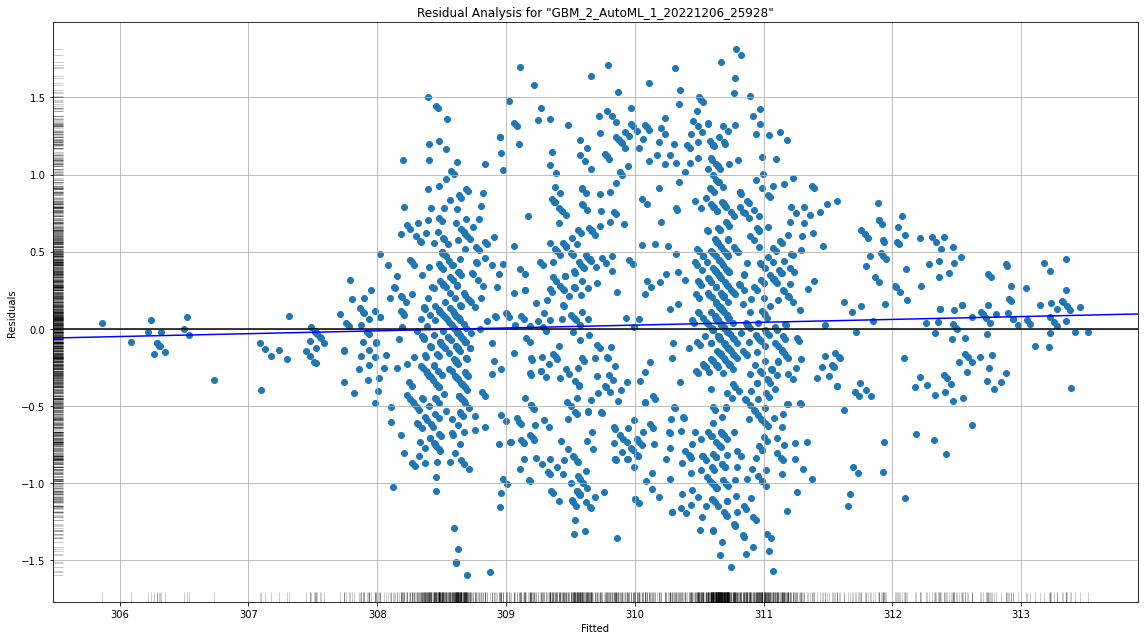

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

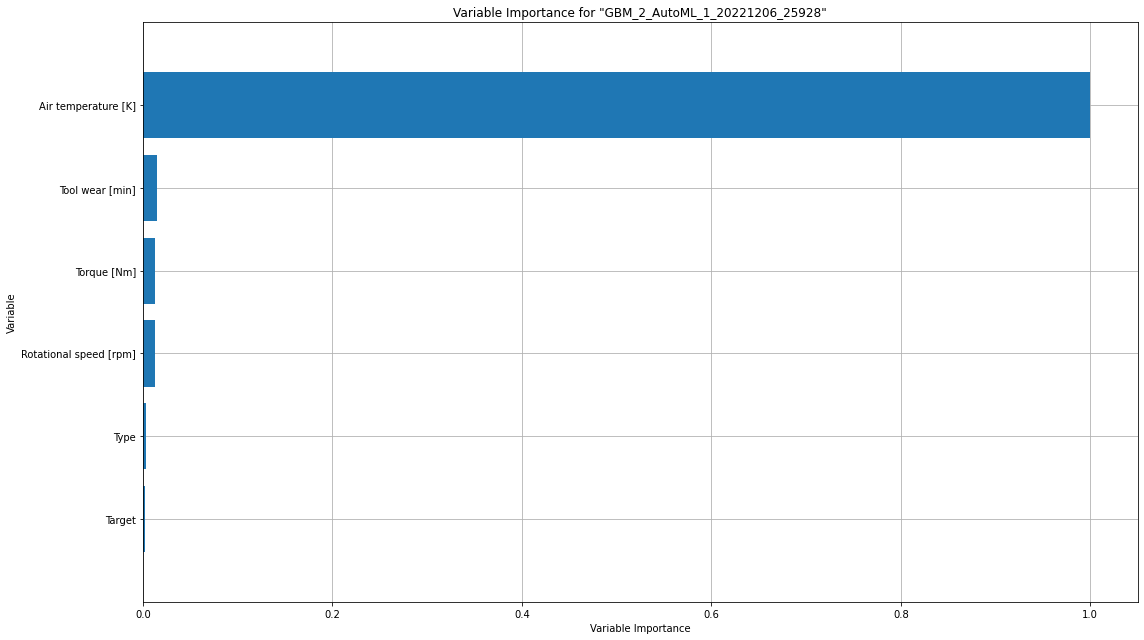

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

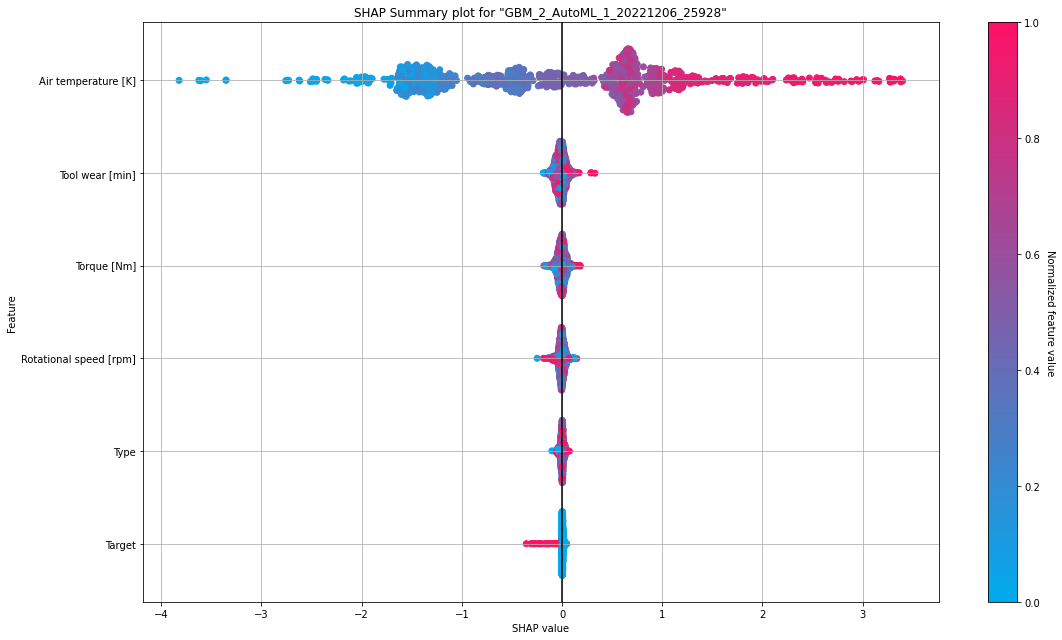

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

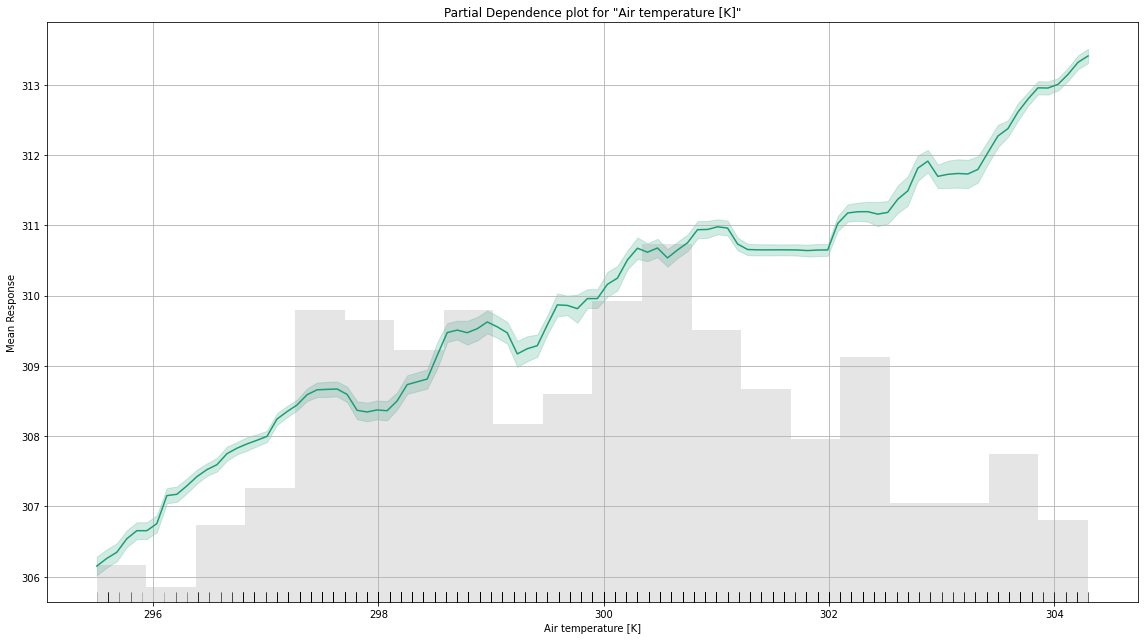

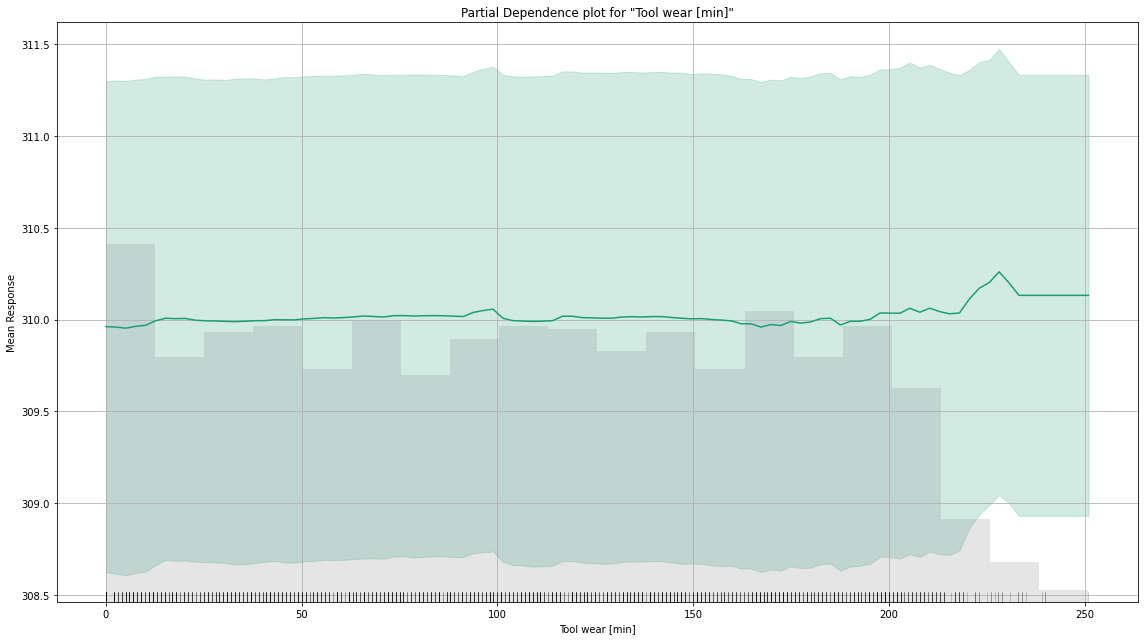

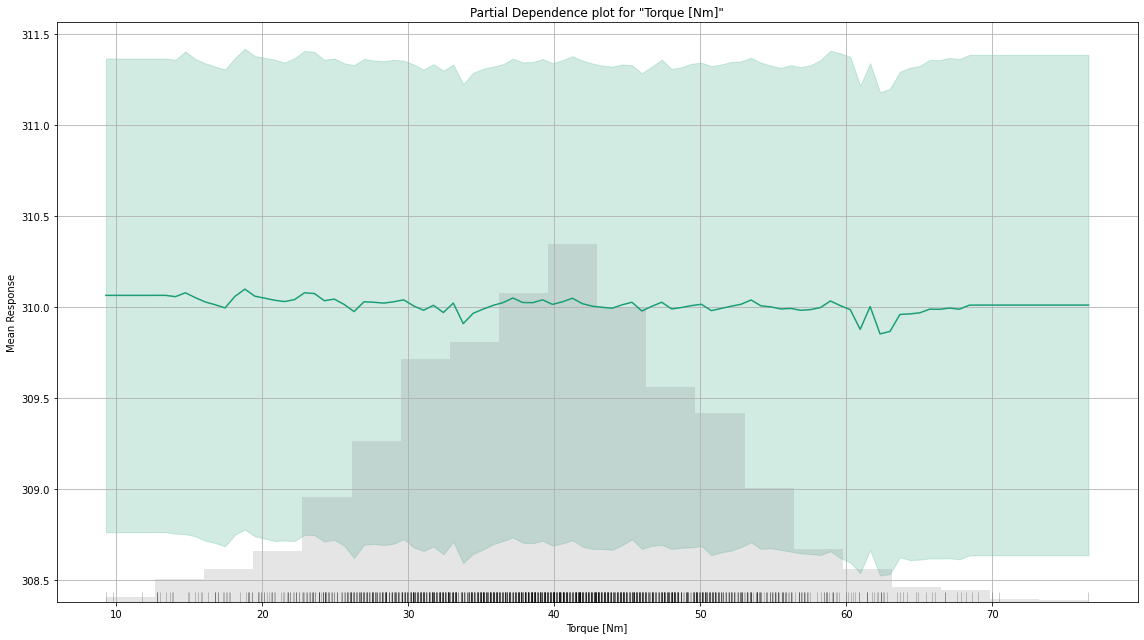

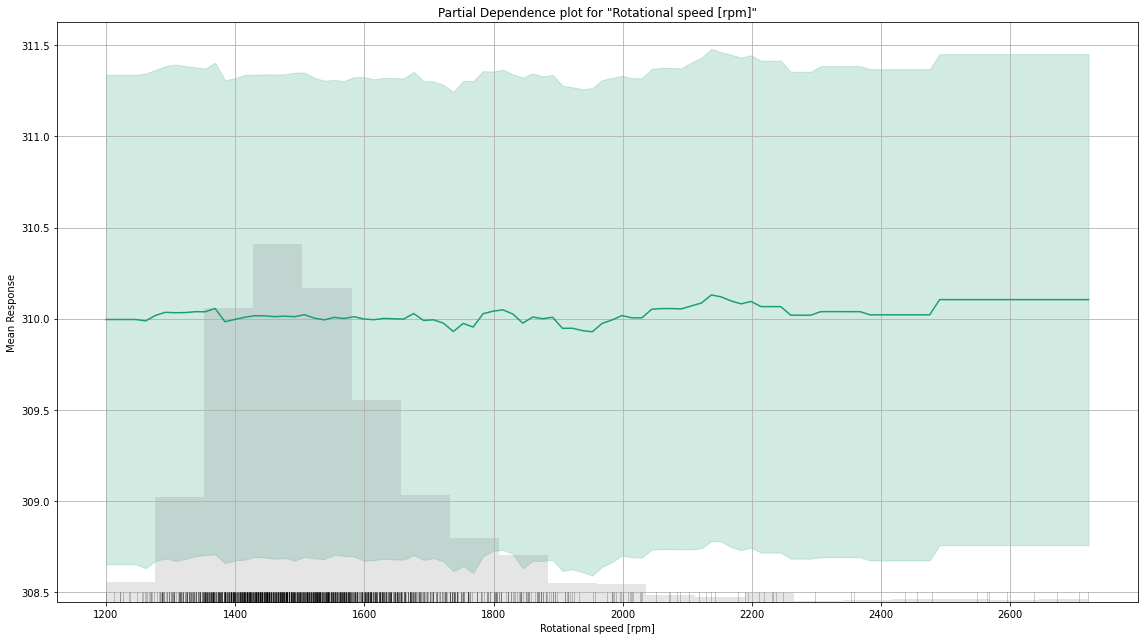

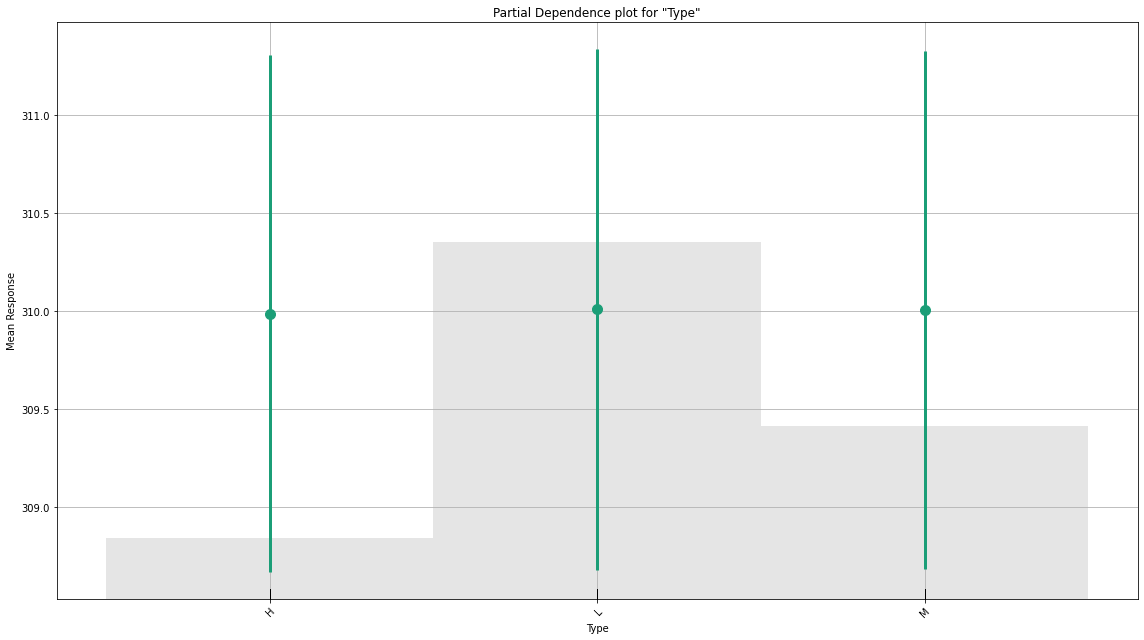

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

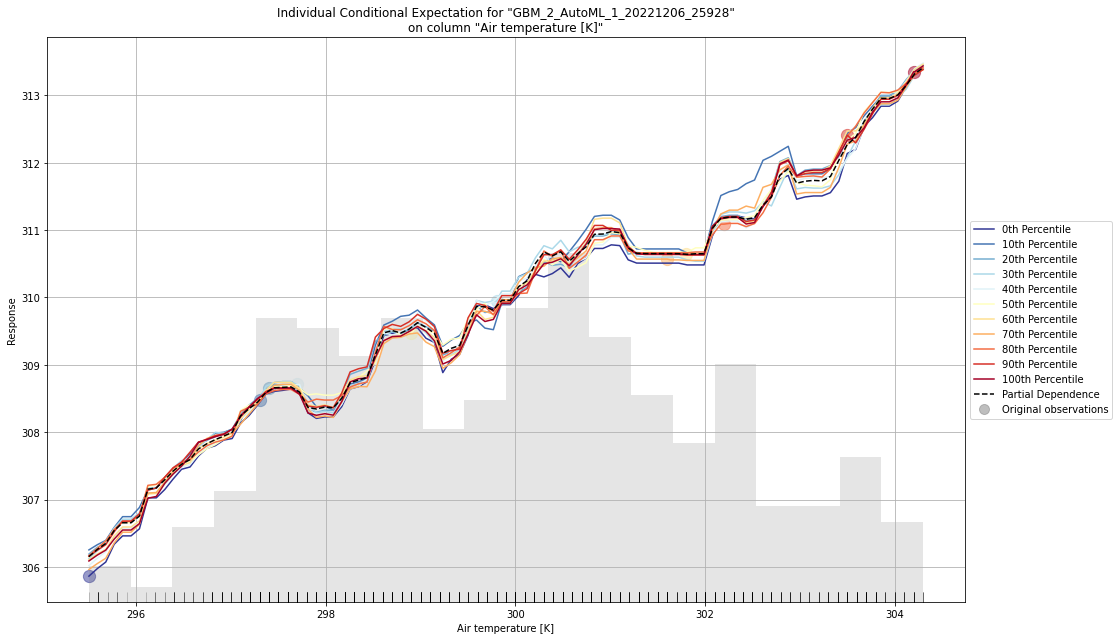

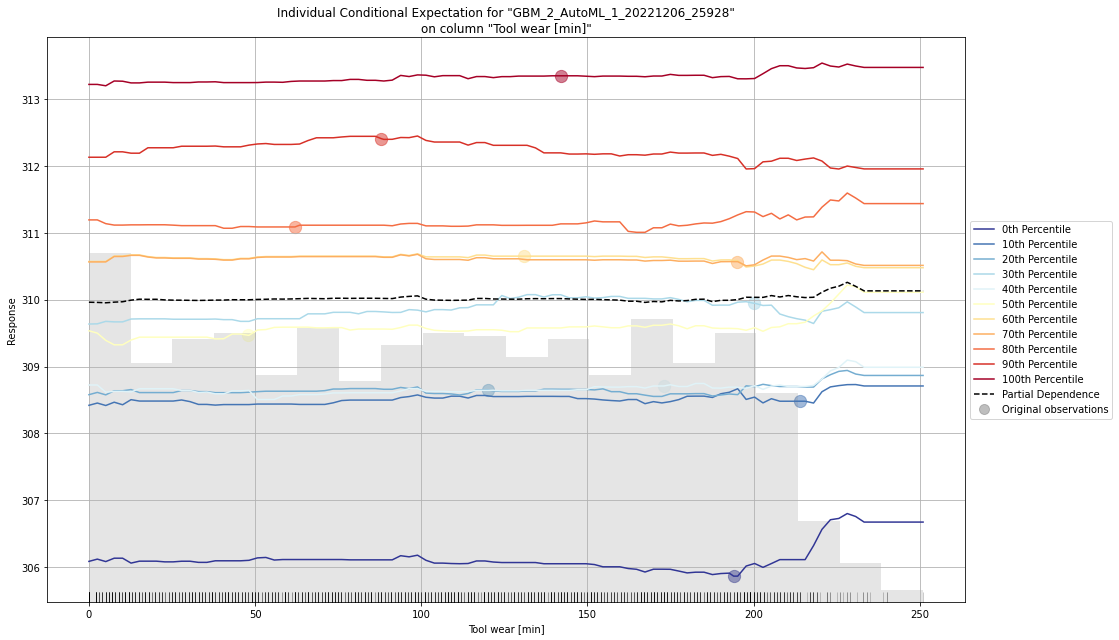

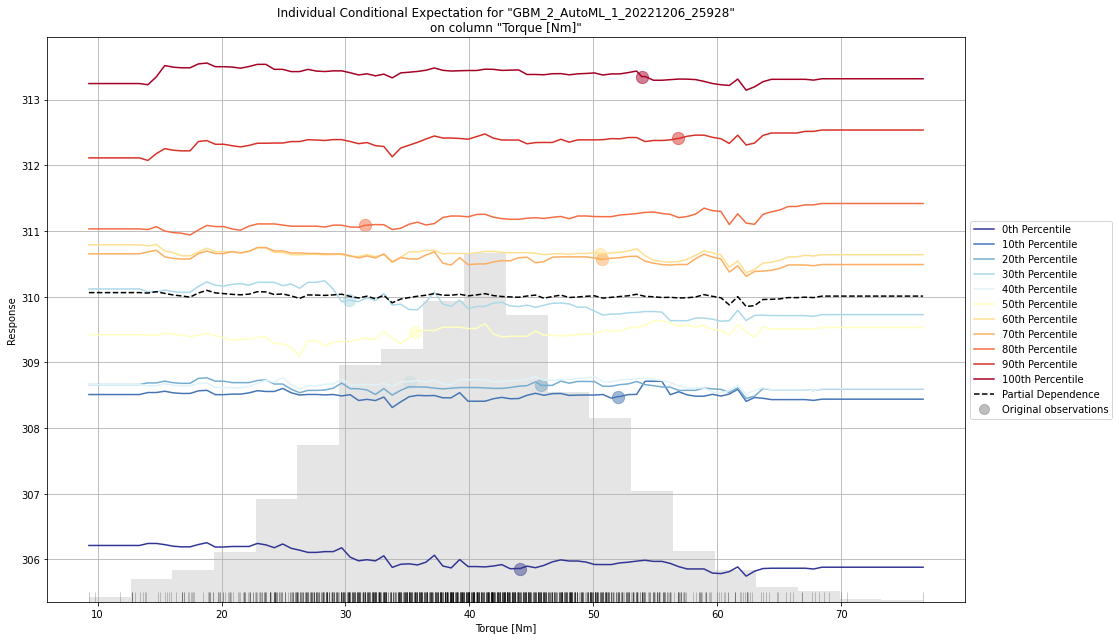

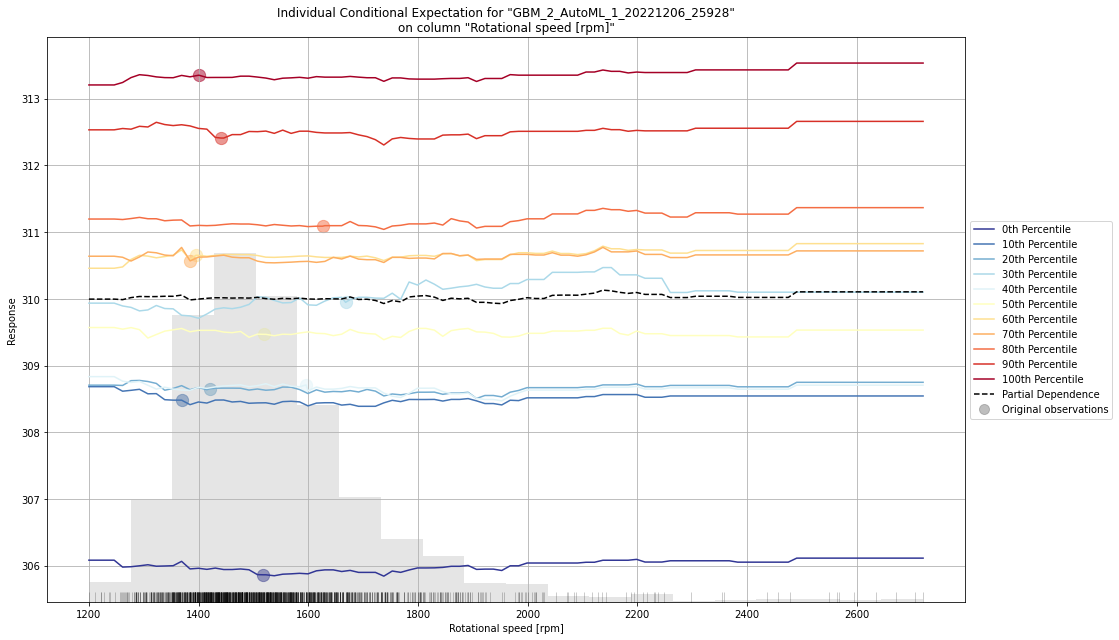

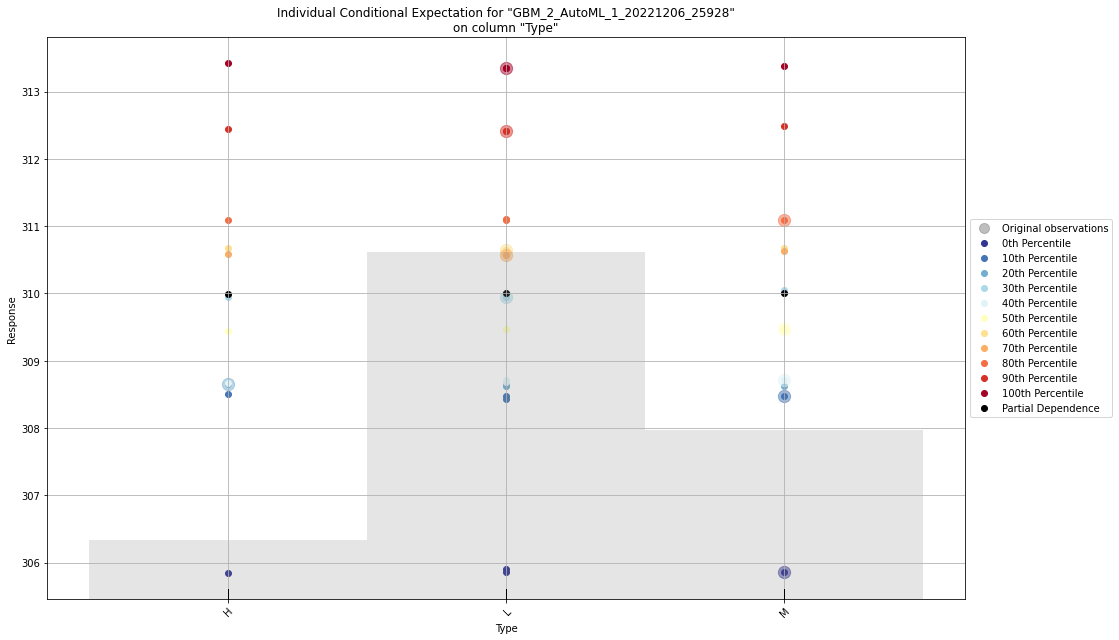

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [72]:
aml.leader.explain(test)

###**Observations**:

From Variable importance graph

- `Air Temperature` shows high importance in predicting the target varible `Process Temperature`. Its very high showing colinearity
- `Type` of a machine has no much importance in predicting target i.e `Process temperature`

From Shap Analysis

- Expect `Air Temperature` other features doesn't show high variation in the impact on traget variable
- Higher the `Air temperature` higher the `Process Temperature` showing high colinearity again , this is justified in PDP plot of `Air Temperature` too
- High population of `Target` variable with a failure class shows same impact on dependent variable
- `Tool wear` when high shows more `Process Temperature`, but low process temperature has mixture of medium and less tool wear


###**Conclusion**

* In Linear model, SHAP abalysis shows similar inference like the feature importance approaches like OLS regression
* In a treebased model the inferences from feature importance and SHAP are almost same how ever they are a bit different on same traget variable comparing to linear modeling
* SHAP helps us in understanding the importance of a feature in a row level and fairly showing the population density at that instant
* for `Type` variable different models showed different impact on the same traget 
* Constantly `Air temperature` showed high colinearity with `process temperature` and a fair distribution in shap graph
* In a tree based model `Rotational speed` showed high importance on `process Temperature` while other models showed `Air Temperature` as an important feature over every other
* `Air temperature` showed linear relationship with `process temperature` in partial dependency plot in AutoML


### Refrences:

1. H2O.ai documentation https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html
2. H2O.ai notebook reference on a different dataset for classification https://colab.research.google.com/github/srivatsan88/YouTubeLI/blob/master/H2O_AutoML.ipynb#scrollTo=vOxeivTyUCeq
3. H2O.ai model explainability https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html
4. permutation importance is refered from scikit-learn permutation handling concept document https://scikit-learn.org/stable/modules/permutation_importance.html
5. modeling is refered from scikit-learn logistic regression officiakl documentatio
6. Outlier Imputation is refered from sklearn "logistic-regression-using-python-and-excel" explanation
7. Refered Kaggle contributions for oversampling 
8. Outlier handling is referec from analytics vidhya outlier handling theoritical explanation https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/
9. Shap Analysis is refered from https://www.analyticsvidhya.com/blog/2021/11/model-explainability/

All other code and function implementation are independently written.


###Copyright 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.